In [100]:
import rasterio
import glob
from matplotlib import pyplot as plt
from rasterio.plot import show, show_hist
import numpy as np
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd

In [101]:
file_pattern = r'D:\projects\gis_projects\water_sar\landsat\l08\*.tif'
imgs = glob.glob(file_pattern)
imgs.sort()
file_out = r'D:\projects\gis_projects\water_sar\landsat\l08'

In [102]:
imgs

['D:\\projects\\gis_projects\\water_sar\\landsat\\l08\\LT05_L2SP_145026_20080727_20200829_02_T1_SR_B1.TIF',
 'D:\\projects\\gis_projects\\water_sar\\landsat\\l08\\LT05_L2SP_145026_20080727_20200829_02_T1_SR_B2.TIF',
 'D:\\projects\\gis_projects\\water_sar\\landsat\\l08\\LT05_L2SP_145026_20080727_20200829_02_T1_SR_B3.TIF',
 'D:\\projects\\gis_projects\\water_sar\\landsat\\l08\\LT05_L2SP_145026_20080727_20200829_02_T1_SR_B4.TIF',
 'D:\\projects\\gis_projects\\water_sar\\landsat\\l08\\LT05_L2SP_145026_20080727_20200829_02_T1_SR_B5.TIF',
 'D:\\projects\\gis_projects\\water_sar\\landsat\\l08\\LT05_L2SP_145026_20080727_20200829_02_T1_SR_B7.TIF']

In [103]:
normalized_imgs = []
def normalize(img_list):
    for img in img_list:
        arr = rasterio.open(img).read(1)
        arr_min, arr_max = arr.min(), arr.max()
        normalized_img = ((arr - arr_min)/(arr_max - arr_min))
        normalized_imgs.append(normalized_img)

In [104]:
normalize(imgs)

In [105]:
len(normalized_imgs)

6

In [106]:
mosaic = np.stack(normalized_imgs, axis=0)
with rasterio.open(imgs[0]) as src:
    meta = src.meta.copy()
# Update the metadata for the mosaic
meta.update(count=mosaic.shape[0], dtype='float32')

In [107]:
with rasterio.open(file_out + '\mosaic.tif', 'w', **meta) as dst:
    dst.write(mosaic)
    dst.close()

In [108]:
with rasterio.open(file_out + '\mosaic.tif') as src:
    green = src.read(3)
    swir = src.read(5)
    
    ndwi = (green - swir) / (green + swir)

    water_mask = np.where(ndwi > -0.07, 1, 0)
    
    with rasterio.open(file_out + r'\ndwi.tif', 'w', driver='Gtiff',
                                    width=src.width,
                                    height=src.height,
                                    count=1,
                                    crs=src.crs,
                                    transform=src.transform,
                                    dtype='float32') as dst:
        dst.write(ndwi, 1)
        dst.close()
    
    with rasterio.open(file_out + '\water_mask.tif', 'w', driver='Gtiff',
                                    width=src.width,
                                    height=src.height,
                                    count=1,
                                    crs=src.crs,
                                    transform=src.transform,
                                    dtype='float32') as dst:
        dst.write(water_mask, 1)
        dst.close

C:\Users\karasu\AppData\Local\Temp\ipykernel_7344\736363610.py:5: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - swir) / (green + swir)


In [109]:
# Read the mask data from the raster file
with rasterio.open(file_out + '\water_mask.tif') as src:
    mask = src.read(1)

# Convert the mask to a vector
geoms = shapes(mask, transform=src.transform)

# Convert the geometries to shapely objects and add any desired attributes
records = []
for geom, value in geoms:
    records.append({'geometry': shape(geom), 'value': value})
gdf = gpd.GeoDataFrame.from_records(records)

# Set the coordinate reference system of the GeoDataFrame to match the raster
gdf.crs = src.crs

# Write the GeoDataFrame to a shapefile
gdf.to_file(file_out + '\water_mask.shp')

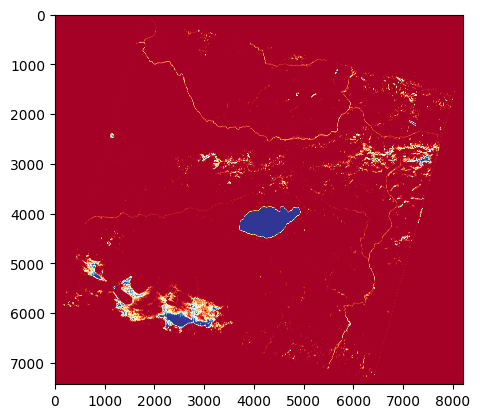

<Axes: >

In [110]:
uav_ndvi = rasterio.open(file_out + r'\water_mask.tif')
uav_ndvi_r = uav_ndvi.read()
show(uav_ndvi_r, cmap='RdYlBu')

In [116]:
mask = uav_ndvi_r > 0.2
import geopandas as gpd
shp = glob.glob(r'D:\projects\gis_projects\water_sar\landsat\**\*.shp')
for i in shp:
    # Load the shapefile into a GeoDataFrame
    gdf = gpd.read_file(i)

    # Calculate the area of each polygon
    gdf['area'] = gdf.geometry.area/1000000

    # Print the GeoDataFrame with the new columns
    print(gdf)

   value     Field         ar  \
0    1.0  454.5684  454.83849   

                                            geometry      area  
0  POLYGON ((417375.000 5409045.000, 417705.000 5...  454.5684  
   value                                           geometry      area
0    1.0  POLYGON ((417585.000 5409015.000, 417645.000 5...  428.8572
   value                                           geometry      area
0    1.0  POLYGON ((417345.000 5409015.000, 417735.000 5...  452.2356
   value                                           geometry     area
0    1.0  POLYGON ((417345.000 5409015.000, 417735.000 5...  452.385
   value                                           geometry     area
0    1.0  POLYGON ((417345.000 5409015.000, 417705.000 5...  452.547
   value                                           geometry      area
0    1.0  POLYGON ((417585.000 5409015.000, 417675.000 5...  451.2726
       value                                           geometry        area
0        1.0  POLYGON ((355725.